In [1]:
import numpy as np
import math
import scipy.stats
import matplotlib.pyplot as plt
from filterpy.monte_carlo import systematic_resample
import math

In [2]:
def calc_input():
    v = 1.0  # [m/s]
    yawrate = 0.1  # [rad/s]
    u = np.array([[v, yawrate]]).T
    return u

In [3]:
def observation(xTrue, xd, u):

    xTrue = motion_model(xTrue, u)

    # add noise to GPS x-y
    zx = xTrue[0, 0] + np.random.randn() * GPS_Noise[0, 0]
    zy = xTrue[1, 0] + np.random.randn() * GPS_Noise[1, 1]
    z = np.array([[zx, zy]])

    # add noise to input
    ud1 = u[0, 0] + np.random.randn() * Input_Noise[0, 0]
    ud2 = u[1, 0] + np.random.randn() * Input_Noise[1, 1]
    ud = np.array([[ud1, ud2]]).T

    xd = motion_model(xd, ud)

    return xTrue, z, xd, ud

In [4]:
def motion_model(x, u):
    F = np.array([
        [1, 0, 0, 0],
        [0, 1, 0, 0],
        [0, 0, 1, 0],
        [0, 0, 0, 0],
    ])

    B = np.array([
        [np.cos(x[2])[0], 0],
        [np.sin(x[2])[0], 0],
        [0, dt],
        [1, 0],
    ])
    
    x = F.dot(x) + B.dot(u)
    
    return x

In [5]:
def plot_covariance_ellipse(xEst, PEst):
    Pxy = PEst[0:2, 0:2]
    eigval, eigvec = np.linalg.eig(Pxy)

    if eigval[0] >= eigval[1]:
        bigind = 0
        smallind = 1
    else:
        bigind = 1
        smallind = 0

    t = np.arange(0, 2 * math.pi + 0.1, 0.1)
    a = math.sqrt(eigval[bigind])
    b = math.sqrt(eigval[smallind])
    x = [a * math.cos(it) for it in t]
    y = [b * math.sin(it) for it in t]
    angle = math.atan2(eigvec[bigind, 1], eigvec[bigind, 0])
    R = np.array([[math.cos(angle), math.sin(angle)],
                  [-math.sin(angle), math.cos(angle)]])
    fx = R.dot(np.array([[x, y]]))
    px = np.array(fx[0, :] + xEst[0, 0]).flatten()
    py = np.array(fx[1, :] + xEst[1, 0]).flatten()
    plt.plot(px, py, "--r")

In [6]:
# Estimation parameters of EKF
Q = np.diag([0.1, 0.1, np.deg2rad(1.0), 1.0])**2  # predict state covariance
R = np.diag([1.0, 1.0])**2  # Observation x,y position covariance

#  Simulation parameter
GPS_Noise = np.diag([0.5, 0.5])**2
Input_Noise = np.diag([1.0, np.deg2rad(30.0)])**2

dt = 0.1  # time tick [s]
SIM_TIME = 50.0  # simulation time [s]

show_animation = True

In [7]:
from numpy.random import uniform

def create_uniform_particles(x_range, y_range, hdg_range, N):
    particles = np.empty((N, 3))
    particles[:, 0] = uniform(x_range[0], x_range[1], size=N)
    particles[:, 1] = uniform(y_range[0], y_range[1], size=N)
    particles[:, 2] = uniform(hdg_range[0], hdg_range[1], size=N)
    particles[:, 2] %= 2 * np.pi
    return particles

def create_gaussian_particles(mean, std, N):
    particles = np.empty((N, 3))
    particles[:, 0] = mean[0] + (randn(N) * std[0])
    particles[:, 1] = mean[1] + (randn(N) * std[1])
    particles[:, 2] = mean[2] + (randn(N) * std[2])
    particles[:, 2] %= 2 * np.pi
    return particles

In [8]:
def predict(particles, u, std, dt=1.):
    """ move according to control input u (heading change, velocity)
    with noise Q (std heading change, std velocity)`"""

    N = len(particles)
    # update heading
    particles[:, 2] += u[0] + (randn(N) * std[0])
    particles[:, 2] %= 2 * np.pi

    # move in the (noisy) commanded direction
    dist = (u[1] * dt) + (randn(N) * std[1])
    particles[:, 0] += np.cos(particles[:, 2]) * dist
    particles[:, 1] += np.sin(particles[:, 2]) * dist

In [9]:
def update(particles, weights, z, R, landmarks):
    for i, landmark in enumerate(landmarks):
        distance = np.linalg.norm(particles[:, 0:2] - landmark, axis=1)
        weights *= scipy.stats.norm(distance, R).pdf(z[i])

    weights += 1.e-300      # avoid round-off to zero
    weights /= sum(weights) # normalize

In [10]:
def estimate(particles, weights):
    """returns mean and variance of the weighted particles"""

    pos = particles[:, 0:2]
    mean = np.average(pos, weights=weights, axis=0)
    var  = np.average((pos - mean)**2, weights=weights, axis=0)
    return mean, var

In [11]:
def simple_resample(particles, weights):
    N = len(particles)
    cumulative_sum = np.cumsum(weights)
    cumulative_sum[-1] = 1. # avoid round-off error
    indexes = np.searchsorted(cumulative_sum, random(N))

    # resample according to indexes
    particles[:] = particles[indexes]
    weights.fill(1.0 / N)

In [12]:
def neff(weights):
    return 1. / np.sum(np.square(weights))

In [13]:
def resample_from_index(particles, weights, indexes):
    particles[:] = particles[indexes]
    weights.resize(len(particles))
    weights.fill (1.0 / len(weights))

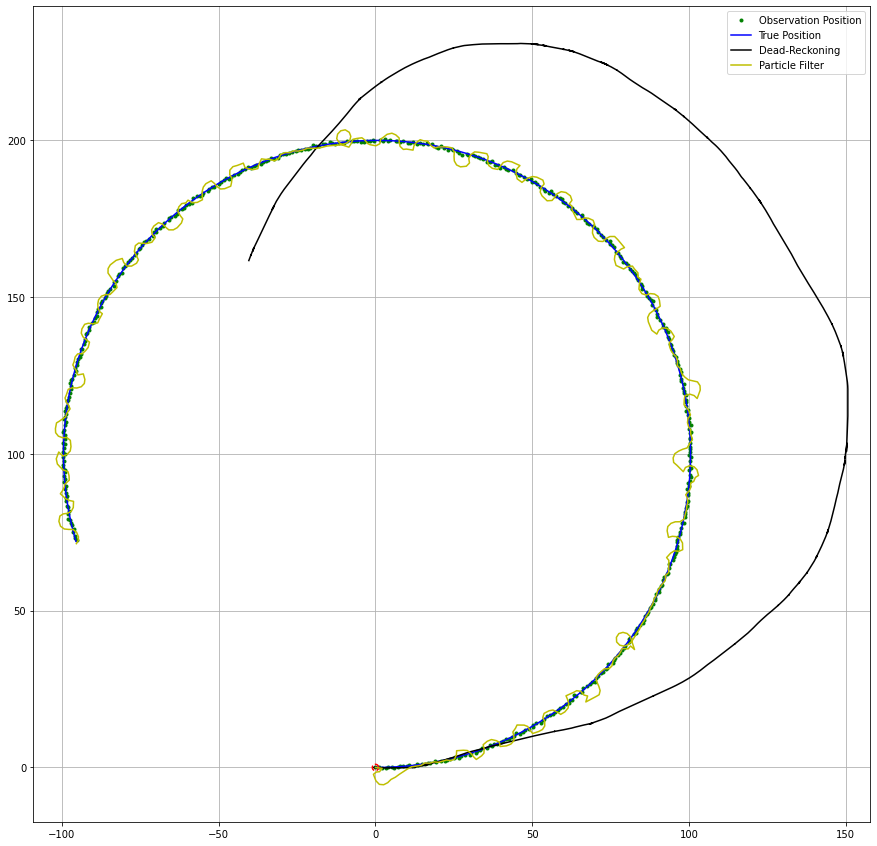

In [14]:
from filterpy.monte_carlo import systematic_resample
from numpy.linalg import norm
from numpy.random import randn
import scipy.stats


def main():
    np.random.seed(91235)
    time = 0.0

    # State Vector [x y yaw v]'
    xEst = np.zeros((4, 1))
    xTrue = np.zeros((4, 1))
    PEst = np.eye(4)

    xDR = np.zeros((4, 1))  # Dead reckoning
    show_animation = True
    # history
    hxEst = xEst
    hxTrue = xTrue
    hxDR = xTrue
    hxmu = np.array(xTrue[:2])
    hz = np.zeros((1, 2))


    N = 1000

    # Particles
    landmarks = np.array([[0, 0],[100, 100],[0, 200],[-100, 100]])
    NL = len(landmarks)


    # create particles and weights

    particles = create_uniform_particles((0,40), (0,40), (0, 6.28), N)
    weights = np.ones(N) / N   

    xs = []
    robot_pos = np.array([0., 0.])
    sensor_std_err = 0.5

    while SIM_TIME >= time:
        time += dt
        u = calc_input()

        xTrue, z, xDR, ud = observation(xTrue, xDR, u)

        # store data history

        hxEst = np.hstack((hxEst, xEst))
        hxDR = np.hstack((hxDR, xDR))
        hxTrue = np.hstack((hxTrue, xTrue))
        hz = np.vstack((hz, z))

        # print(z)
        robot_pos = z

        zs = (norm(landmarks - robot_pos, axis=1) + (randn(NL) * sensor_std_err))

        # move diagonally forward to (x+1, x+1)
        predict(particles, u=(0.00, 1.414), std=(.2, .05))
        
        # incorporate measurements
        update(particles, weights, z=zs, R=sensor_std_err, 
               landmarks=landmarks)
        
        # resample if too few effective particles
        if neff(weights) < N/2:
            indexes = systematic_resample(weights)
            resample_from_index(particles, weights, indexes)
            assert np.allclose(weights, 1/N)
        mu, var = estimate(particles, weights)

        hxmu = np.hstack((hxmu, np.array([mu]).T))

    plt.figure(figsize=(15, 15))

    plt.plot(hz[:, 0], hz[:, 1], ".g",label="Observation Position")
    plt.plot(hxTrue[0, :].flatten(), hxTrue[1, :].flatten(), "-b",label="True Position")
    plt.plot(hxDR[0, :].flatten(), hxDR[1, :].flatten(), "-k",label="Dead-Reckoning")
    
    plot_covariance_ellipse(xEst, PEst)
    
    plt.axis("equal")
    plt.grid(True)
    plt.plot(hxmu[0, :].flatten(), hxmu[1, :].flatten(), "-y",label="Particle Filter")
    plt.legend()
    plt.show()
    
    
main()